# Image Classifiers with Keras

In [1]:
import cv2
import os
import sys
import glob
import numpy as np
import pandas as pd

from PIL import Image

from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

Using TensorFlow backend.


## ImageNet Classification

The `keras.applications` module provides easy access to ImageNet ILSVRC competition-winning convolutional neural network models, which can recognize 1,000 common object classes.
Below I've used one of the off-the-shelf architectures, `ResNet50` (developed by Microsoft Research), to classify image content.

In [2]:
# load the ResNet50 model using weights pre-trained on the ImageNet dataset
resnet50 = ResNet50(weights='imagenet')

In [3]:
def predict(model, img, top_n=5):
    """
    model: keras model
    img: image in PIL format 
    target_size: (width, height) tuple
    top_n: # of top predictions to return
    
    Returns: list of predicted labels and their probabilities
    """
    if img.size != (224, 224): # ResNet50 architecture uses (224, 224)
        img = img.resize((224, 224))
    
    x = image.img_to_array(img) # converts PIL image to numpy array
    x = np.expand_dims(x, axis=0) # converts (3, 224, 224) size image to (1, 3, 224, 224)
    # model.predict function requires 4-dimensional array as input, where 4th dimension corresponds to batch size
    # this means we can classify multiple images at once
    x = preprocess_input(x) # data normalization
    # zero-centers image data using the mean channel values from training dataset
    # extremely import step -- if skipped, all predicted probabilities will be incorrect
    preds = model.predict(x)
    return decode_predictions(preds, top=top_n)[0]

In [4]:
img1 = Image.open('/home/darby/Downloads/meow_data/train/meow/meow972.jpg')
img2 = Image.open('/home/darby/Downloads/meow_data/train/meow/meow850.jpg')
decoded_probs1 = predict(resnet50, img1)
decoded_probs2 = predict(resnet50, img2)

In [5]:
def plot_preds(image1, image2, preds1, preds2):
    """
    image: 2 PIL images
    preds: list of predicted labels and their probabilities for each image
    """
    fig = plt.figure(figsize=(12,7))
    axes = ['ax{}'.format(i) for i in np.arange(4)]
    gs = gridspec.GridSpec(3,2)
    axes[0] = plt.subplot(gs[:2,0])
    axes[1] = plt.subplot(gs[2,0])
    axes[2] = plt.subplot(gs[:2,1])
    axes[3] = plt.subplot(gs[2,1])
    
    for image, ax in zip([image1, image2], [axes[0], axes[2]]):
        ax.imshow(image)
        ax.axis('off')

    for preds, ax in zip([preds1, preds2], [axes[1], axes[3]]):
        order = list(reversed(np.arange(len(preds))))
        bar_preds = [pr[2] for pr in preds]
        labels = [pr[1] for pr in preds]
        labels.append('')

        ax.barh(order, bar_preds, alpha=0.5)
        ax.set_yticklabels(reversed(labels))
        ax.set_xlabel('Probability')
        ax.set_xlim(0, 1)
        
    gs.tight_layout(fig)

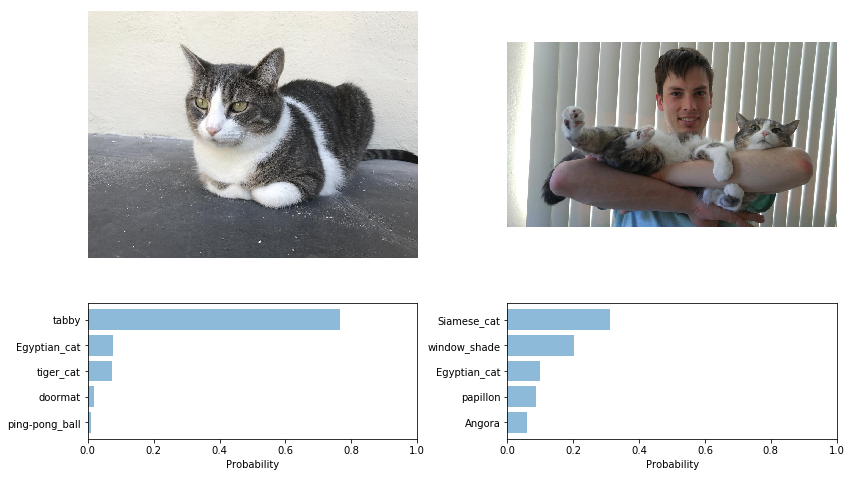

In [6]:
plot_preds(img1, img2, decoded_probs1, decoded_probs2)

As the output shows, the ImageNet dataset contains several cat classes among its 1000 classes.
* Image on the left: 
    * In this simple picture of my cat, Meow (no background distractions), _tabby_ is overwhelmingly the top prediction.
* Image on the right: 
    * Predicted probabilities are more spread out. 
    * Although Meow is incorrectly recognized as a _siamese cat_, the model correctly picked out _window shade_ in the background.

## Building Meow Classifier via Transfer Learning

I followed this [Keras tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) to build a custom classifier -- one that can distinguish my cat from other cats.

I used only 2000 pictures for training (split equally between my cat vs other cats) and 352 additional samples from each class as validation data.
Despite using a small image dataset, I was able to build a powerful model via transfer learning that can identify my Meow with high accuracy.
I leveraged the VGG16 architecture pre-trained on the ImageNet dataset, which has already learned features that are relevant to this classification challenge (especially given that it can distinguish between different cat breeds).

Transfer learning steps:
1. Use the bottleneck features of the pre-trained network
2. Fine-tuning the top layers of the pre-trained network

In [7]:
# downsize Meow pics 
meow_pics = '/home/darby/Downloads/meow_pics_1200/'

for f in glob.glob(os.path.join(meow_pics, '*.jpg')):
    img = Image.open(f)
    img.thumbnail([1200, 1200], Image.ANTIALIAS)
    img.save(f)

In [8]:
# rename pics so that they're in the format xxx001.jpg, xxx002.jpg, etc
# shuffle the order of meow pics
def rename(directory, meow):
    files = glob.glob(os.path.join(directory, '*.jpg'))
    if meow == 0:
        for f, i in zip(files, np.arange(len(files))):
            os.rename(f, os.path.join(directory, 'notmeow{0:03}.jpg'.format(i+1)))
    if meow == 1:
        for f, i in zip(files, np.random.choice(np.arange(1, len(files) + 1), size=len(files), replace=False)):
            os.rename(f, os.path.join(directory, 'meow{0:03}.jpg'.format(i)))

With the `rename` function, I organized my training & validation dataset directory in the following format:

    meow_data/
        train/
            meow/
                meow001.jpg
                meow002.jpg
                ...
                meow1000.jpg
            notmeow/
                notmeow001.jpg
                notmeow002.jpg
                ...
                notmeow1000.jpg
        test/
            meow/
                meow001.jpg
                meow002.jpg
                ...
                meow352.jpg
            notmeow/
                notmeow001.jpg
                notmeow002.jpg
                ...
                notmeow352.jpg

### Using the bottleneck features of a pre-trained network

1. Only instantiate the convolutional part of the model (everything up to the fully-connected layers)
2. Run this model on the training and validation data once, recording the output (the "bottleneck features" from the VGG16 model) in two numpy arrays
    * Bottleneck features are the last activation maps before the fully-connected layers
    * For computational efficiency, store the features offline rather than adding the fully-connected model directly on top of a frozen convolutional base & running the whole thing
3. Train a small fully-connected model on top of the stored features

In [9]:
train_data_dir = '/home/darby/Downloads/meow_data/train/'
validation_data_dir = '/home/darby/Downloads/meow_data/test/'

img_width, img_height = 150, 150 # using small image size (the default input size for VGG16 is 224x224)
nb_train_samples = 2000 # combined number of meow & notmeow training pics
nb_validation_samples = 704 # combined number of meow & notmeow testing pics
epochs = 50
batch_size = 16

In [10]:
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=batch_size,
                                            class_mode=None,  # only yield batches of data, no labels
                                            shuffle=False) # data will be in order
    
    # the predict_generator method returns the output of a model, given a generator that yields batches of numpy data
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    # save the output as a numpy array
    np.save('bottleneck_features_train', bottleneck_features_train)

    generator = datagen.flow_from_directory(validation_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=batch_size,
                                            class_mode=None,
                                            shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples // batch_size)
    np.save('bottleneck_features_validation', bottleneck_features_validation)

In [11]:
# check the shape of the saved data
np.load('bottleneck_features_train.npy').shape, np.load('bottleneck_features_validation.npy').shape

((2000, 4, 4, 512), (704, 4, 4, 512))

In [12]:
def train_top_model():
    """
    Load saved data and train a small fully-connected model
    """
    train_data = np.load('bottleneck_features_train.npy')
    # features were saved in order - assign 0 to the first half and 1 to the second half
    train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

    validation_data = np.load('bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
        
    checkpoint_w = ModelCheckpoint('bottleneck_fc_weights.h5', monitor='val_acc', mode='max',
                                 save_weights_only=True, save_best_only=True)
    
    checkpoint_m = ModelCheckpoint('bottleneck_fc_model.h5', monitor='val_acc', mode='max',
                                 save_weights_only=False, save_best_only=True)

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint_w, checkpoint_m])

Thanks to its small size, this model trained very quickly even on CPU (4s per epoch)

In [13]:
# model from train_top_model
validation_data = np.load('bottleneck_features_validation.npy')
validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))
load_model('bottleneck_fc_model.h5').evaluate(validation_data, validation_labels)

480/704 [===================>..........] - ETA: 0s

[0.60726650922813197, 0.92613636363636365]

### Fine-tuning the top layers of a pre-trained network

1. Instantiate the convolutional base of VGG16 and load its weights
2. Add the previously defined fully-connected model on top and load its weights
3. Freeze the layers of the VGG16 model up to the last convolutional block
4. Train the whole thing with a very slow learning rate

In [14]:
# build the VGG16 network
model_vgg = applications.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# path to the model weights files
top_model_weights_path = 'bottleneck_fc_weights.h5'

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=model_vgg.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# must start with a fully-trained classifier (including the top classifier) in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
model = Model(inputs=model_vgg.input, outputs=top_model(model_vgg.output))

# set the first 25 layers (up to the last conv block) to non-trainable (weights will not be updated)
for layer in model.layers[:25]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer and a very slow learning rate
# This is to make sure that the magnitude of the updates stays very small, so as not to wreck the previously learned features
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 704 images belonging to 2 classes.


In [15]:
def fine_tune():
    checkpoint_w = ModelCheckpoint('vgg_finetuning_weights_best.h5', monitor='val_acc', mode='max',
                                 save_weights_only=True, save_best_only=True)

    checkpoint_m = ModelCheckpoint('vgg_finetuning_model_best.h5', monitor='val_acc', mode='max',
                                 save_weights_only=False, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=8, verbose=1, mode='max')

    # fine-tune the model
    model.fit_generator(train_generator,
                        steps_per_epoch=nb_train_samples // batch_size,
                        epochs=epochs,
                        validation_data=validation_generator,
                        validation_steps=nb_validation_samples // batch_size,
                        callbacks=[checkpoint_w, checkpoint_m, early_stopping])
    
    model.save('vgg_finetuning_model.h5')

Each epoch took ~1200s on CPU

In [16]:
model = load_model('vgg_finetuning_model_best.h5')

In [17]:
model.evaluate_generator(validation_generator, nb_validation_samples // batch_size)

[0.62476730707394268, 0.93181818181818177]

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Evaluating the model

In [20]:
test_meow_list = [f for f in glob.glob(os.path.join(validation_data_dir + 'meow', '*jpg'))]
test_notmeow_list = [f for f in glob.glob(os.path.join(validation_data_dir + 'notmeow', '*jpg'))]

In [21]:
meow_probs = []
for f in (test_meow_list + test_notmeow_list):
    img = image.load_img(f, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    prob = 1 - model.predict(x/255)[0, 0]
    meow_probs.append(prob.item())

In [22]:
df_preds = pd.DataFrame({'y_true': np.append(np.ones(len(test_meow_list)), np.zeros(len(test_notmeow_list))).astype(int),
                         'y_prob': meow_probs,
                         'img_dir': [f for f in (test_meow_list + test_notmeow_list)]})

In [23]:
df_preds['y_pred'] = np.where(df_preds.y_prob > 0.5, 1, 0)

In [24]:
df_preds.groupby(['y_true', 'y_pred']).size().unstack('y_true')

y_true,0,1
y_pred,,
0,334,30
1,18,322


In [25]:
# True positive rate (TPR) / recall / sensitivity / probability of detection
# P(y^=1 | y=1)
tpr = 322 / (30 + 321)

# False positive rate (FPR) / Type 1 error rate / fall-out
# P(y^=1 | y=0)
fpr = 18 / (334 + 18)

# Positive predictive value (PPV) / precision
# P(y=1 | y^=1)
precision = 322 / (18 + 322)

In [26]:
from sklearn.metrics import roc_curve, auc, average_precision_score, precision_recall_curve

In [27]:
def plot_curves(y_true, y_prob, fpr_, tpr_, precision_):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # false/true positive rates for different classification thresholds
    fpr, tpr, threshold = roc_curve(y_true, y_prob, drop_intermediate=False)
    roc_auc = auc(fpr, tpr)

    # plot ROC curve
    ax1.set_title('ROC Curve: AUC={0:0.4f}'.format(roc_auc))
    ax1.step(fpr, tpr, 'b', where='post')
    ax1.fill_between(fpr, tpr, step='post', alpha=0.1, color='b')
    ax1.plot(fpr_, tpr_, 'yD', markersize=8, label='at threshold=0.5')
    ax1.annotate('({:.2f}, {:.2f})'.format(fpr_, tpr_), xy=(fpr_, tpr_), 
                 xytext=(fpr_ + 0.03, tpr_ - 0.03))
    ax1.plot([0, 1],[0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylim([0, 1.01])
    ax1.set_ylabel('True Positive Rate')
    ax1.legend(loc=4)
    
    average_precision = average_precision_score(y_true, y_prob)
    # precision/recall for different classification thresholds
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    
    # plot PRC curve
    ax2.set_title('Precision-Recall Curve: AUC={0:0.4f}'.format(average_precision)) 
    ax2.step(recall, precision, color='b', where='post')
    ax2.fill_between(recall, precision, step='post', alpha=0.1, color='b')
    ax2.axhline(0.5, color='r', linestyle='dashed')
    ax2.plot(tpr_, precision_, 'yD', markersize=8, label='at threshold=0.5')
    ax2.annotate('({:.2f}, {:.2f})'.format(tpr_, precision_), xy=(tpr_, precision_), 
                 xytext=(tpr_ - 0.25, precision_ - 0.05))
    ax2.set_xlim([0.0, 1.0])
    ax2.set_xlabel('Recall')
    ax2.set_ylim([0.0, 1.01])
    ax2.set_ylabel('Precision')
    ax2.legend(loc=4)

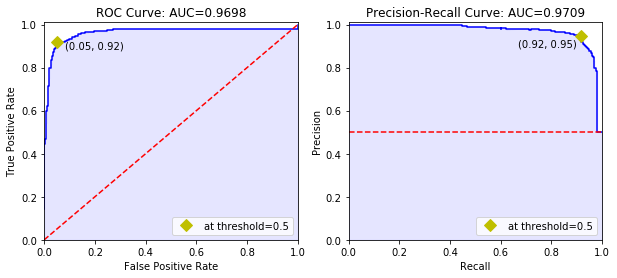

In [28]:
plot_curves(df_preds.y_true, df_preds.y_prob, fpr, tpr, precision)

In [29]:
# Accuracy
(334 + 322) / 704

0.9318181818181818

The model performs well! Now let's play around with some pictures...

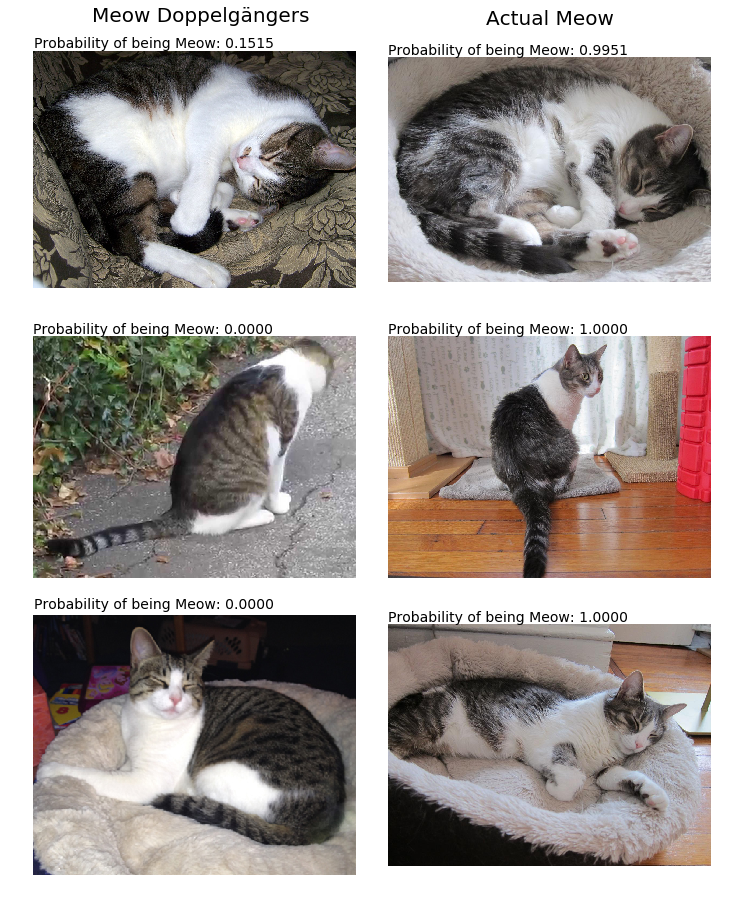

In [30]:
img1 = image.load_img('/home/darby/Downloads/cat-18300_960_720.jpg')
img1 = img1.crop((40, 0, 920, 648))
img2 = image.load_img('/home/darby/Downloads/meow_data/test/meow/meow038.jpg')
img2 = img2.crop((70, 150, 1060, 840))

img3 = image.load_img('/home/darby/Downloads/maxresdefault.jpg')
img4 = image.load_img('/home/darby/Downloads/meow_data/test/meow/meow268.jpg')

img5 = image.load_img('/home/darby/Downloads/Antrim-Irie-bi-color-tabby-Sept-1.jpg')
#img6 = image.load_img('/home/darby/Downloads/meow_data/test/meow/meow101.jpg')
img6 = image.load_img('/home/darby/Downloads/meow_data/test/meow/meow197.jpg')

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10,12))

ax1.text(160, -80, 'Meow Doppelgängers', fontsize=20)
ax2.text(300, -100, 'Actual Meow', fontsize=20)

for img, ax in zip([img1, img2, img3, img4, img5, img6], [ax1, ax2, ax3, ax4, ax5, ax6]):
    ax.imshow(img)
    ax.axis('off')
    
    img = img.resize((img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    ax.text(0, -10, 'Probability of being Meow: {:.4f}'.format(1 - model.predict(x / 255)[0, 0]), fontsize=14)

fig.tight_layout(pad=0.2)

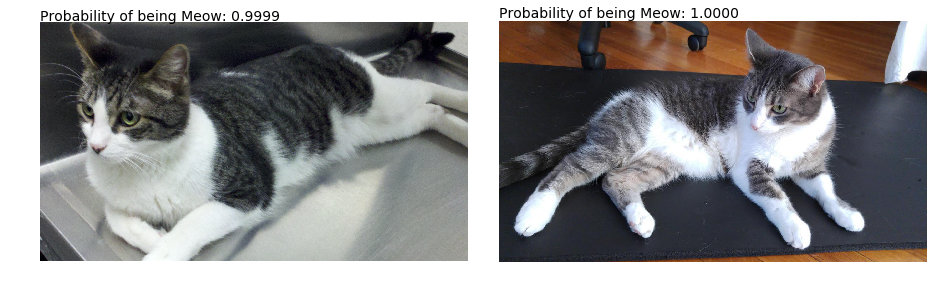

In [31]:
img7 = image.load_img('/home/darby/Downloads/Patches-7.18.12.jpg')
img8 = image.load_img('/home/darby/Downloads/meow_data/test/meow/meow126.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,8))

for img, ax in zip([img7, img8], [ax1, ax2]):
    ax.imshow(img)
    ax.axis('off')
    
    img = img.resize((img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    ax.text(0, -10, 'Probability of being Meow: {:.4f}'.format(1 - model.predict(x / 255)[0, 0]), fontsize=14)

fig.tight_layout(pad=0.2)